In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # tqdm是显示循环进度条的库


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,坐标轴原点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

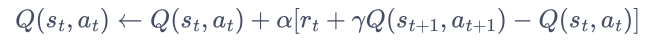  
$$TD\_target=r_{t}+\gamma q_t(s_{t+1},a_{t+1})$$
$$TD\_error=TD\_target- q_t(s_{t},a_{t})$$
$$q_{t+1}(s_{t},a_{t})=q_{t}(s_{t},a_{t})+\alpha* TD\_error$$
$(s_{t},a_{t})$是输入条件，$(r_{t},s_{t+1})$是与环境进行交互得到的  
这里的$a_{t+1}$是使用被更新的$q$对应的策略(目标策略)决定的，  
因此获取训练数据时，必须是用被更新的策略来探索采样(行为策略)  
有$(s_{t},a_{t},r_{t},s_{t+1},a_{t+1})$就可以得到$TD\_target$更新Q(目标策略)，  
下一次通过一定的policy(行为策略)从$s_{t+1}$状态选择action  
行为策略与目标策略是同一个，因此是on-policy

In [3]:
class Sarsa:
    """ Sarsa算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.ones([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

    def update(self, s0, a0, r, s1, a1):
        TD_target=r + self.gamma * self.Q_table[s1, a1]
        TD_error =self.Q_table[s0, a0]-TD_target
        self.Q_table[s0, a0] -= self.alpha * TD_error
        
    def take_action(self, state):  # 选取下一步的操作,具体实现为epsilon-贪婪
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a


Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3371.90it/s, episode=500, return=-28.200]


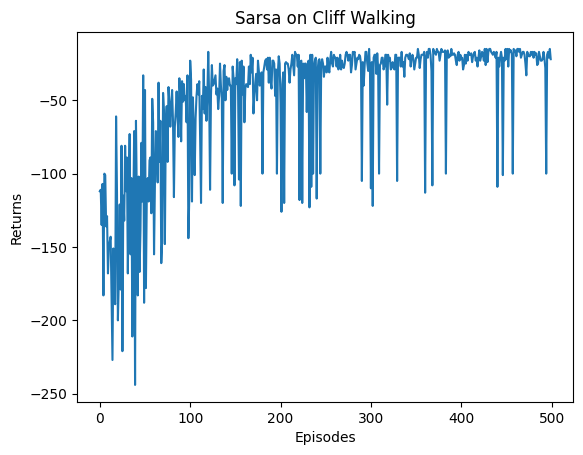

In [4]:
def train_agent_on_policy(env,agent,algrithm_type="sarsa"):
    episode_return = 0
    state = env.reset()
    action = agent.take_action(state)
    done = False
    while not done:
        next_state, reward, done = env.step(action)
        next_action = agent.take_action(next_state)
        episode_return += reward  # 这里回报的计算不进行折扣因子衰减
        if algrithm_type=="sarsa" or algrithm_type==1:
            agent.update(state, action, reward, next_state, next_action)
        elif algrithm_type=="nsarsa" or algrithm_type==2:
            agent.update(state, action, reward, next_state, next_action,done)
        elif algrithm_type=="Q_learning" or algrithm_type==3:
            agent.update(state, action, reward, next_state)
        state = next_state
        action = next_action
    return episode_return

ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量
k=10

return_list = []  # 记录每一条序列的回报
for i in range(k):  # 显示k个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / k), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / k)):  # 每个进度条的序列数
            episode_return = train_agent_on_policy(env,agent)
            return_list.append(episode_return)
            if (i_episode + 1) % k == 0:  # 每k条序列打印一下这k条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / k * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-k:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()


In [5]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])


Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo ooo> ovoo ovoo 
^ooo ^ooo ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ^ooo oo<o oo<o ^ooo ^ooo ^ooo oo<o ooo> ^ooo ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


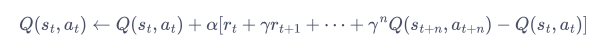  

$TD\_target=r_t+\gamma*r_{t+1}+...+\gamma^{n-1}*r_{t+n-1}+\gamma^{n}*Q(s_{t+n},a_{t+n})$   
使用了$R_0-->R_{n-1}$个信息  
从第0步开始，使用原始策略探索，初始信息为：$S_0$，$A_0$,探索n步得到如下信息：  
从最开始每一次更新传入一个元组$(S_0,A_0,R_0,S_1,A_1)$  
$S=\begin{bmatrix} S_0 & S_1 &... &S_{n-1} &S_n\end{bmatrix}_{1 \times n+1}$  
$A=\begin{bmatrix} A_0 & A_1 &... &A_{n-1} &A_n\end{bmatrix}_{1 \times n+1}$  
$R=\begin{bmatrix} R_0 & R_1 &... &R_{n-1} \end{bmatrix}_{1 \times n}$  
然后对$Q(s_0,a_0)$进行更新  
探索n步后数据足够计算$TD\_target$，至此每一步都要进行计算$TD\_target$，然后更新$Q(s_t,a_t)$   

处理终止条件  
当达到终止状态时，存储的信息有n个，后续没有下一个状态，因此只能更新$Q(s_{t},a_{t})$  
而余下的$Q(s_{t+1},a_{t+1})$~$Q(s_{t+n},a_{t+n})$没有足够的信息进行$TD\_target$计算  
这里从末尾$s_{t+n}$~$s_{t+1}$倒过来计算$G$作为$TD\_target$来更新$Q(s_{t+n},a_{t+n})$~$Q(s_{t+1},a_{t+1})$


Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3620.34it/s, episode=500, return=-18.700]


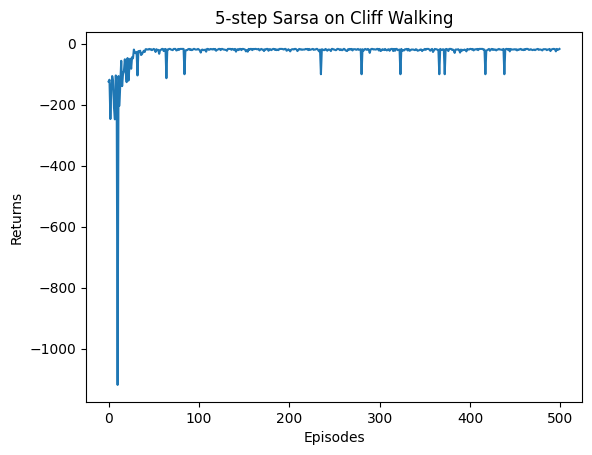

In [6]:
class nstep_Sarsa(Sarsa):
    """ n步Sarsa算法 """
    def __init__(self, n, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        super().__init__(ncol, nrow, epsilon, alpha, gamma, n_action)
        self.n = n  # 采用n步Sarsa算法
        self.state_list = []  # 保存之前的状态
        self.action_list = []  # 保存之前的动作
        self.reward_list = []  # 保存之前的奖励

    def update(self, s0, a0, r, s1, a1, done):
        self.state_list.append(s0) #只存到n个，s1，a1用来查找Q(s_{t+n},a_{t+n})
        self.action_list.append(a0)#只存到n个
        self.reward_list.append(r)#只存到n个

        if len(self.state_list) == self.n:  # 若保存的数据可以进行n步更新
            G = self.Q_table[s1, a1]  # 得到Q(s_{t+n}, a_{t+n})
            for i in reversed(range(self.n)):#倒过来计算G值
                G = self.gamma * G + self.reward_list[i]  # 不断向前计算每一步的回报
                # 如果到达终止状态,最后几步虽然长度不够n步,也将其进行更新
                if done and i > 0: #i=0那一步是正常的TD_target
                    s = self.state_list[i]
                    a = self.action_list[i]
                    self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
            s = self.state_list.pop(0)  # 将需要更新的状态动作从列表中删除,下次不必更新
            a = self.action_list.pop(0)
            self.reward_list.pop(0)
            # n步Sarsa的主要更新步骤
            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])

        if done:  # 如果到达终止状态,即将开始下一条序列,则将列表全清空
            self.state_list = []
            self.action_list = []
            self.reward_list = []


np.random.seed(0)
n_step = 5  # 5步Sarsa算法
alpha = 0.1
epsilon = 0.1
gamma = 0.9
agent = nstep_Sarsa(n_step, ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    #tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = train_agent_on_policy(env,agent,"nsarsa")
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('5-step Sarsa on {}'.format('Cliff Walking'))
plt.show()


In [7]:
action_meaning = ['^', 'v', '<', '>']
print('5步Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])


5步Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ^ooo ^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ovoo 
^ooo oo<o ooo> ^ooo ^ooo ^o<o ooo> oo<o ooo> oo<o ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


$$TD\_target=r_{t}+\gamma \underset {a}{max} q_t(s_{t+1},a_{t+1})$$
$$TD\_error=TD\_target- q_t(s_{t},a_{t})$$
$$q_{t+1}(s_{t},a_{t})=q_{t}(s_{t},a_{t})+\alpha* TD\_error$$
$(s_{t},a_{t})$是输入条件，$(r_{t},s_{t+1})$是与环境进行交互得到的  
有$(s_{t},a_{t},r_{t},s_{t+1})$就可以得到$TD\_target$更新Q(目标策略)，  
下一次通过一定的policy(行为策略)从$s_{t+1}$状态选择$a_{t+1}$  
可见更新目标策略时，目标策略本身不用来产生更新数据，因此目标策略与行为策略不一定是相同的  
off-policy算法


Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 2899.10it/s, episode=500, return=-33.400]


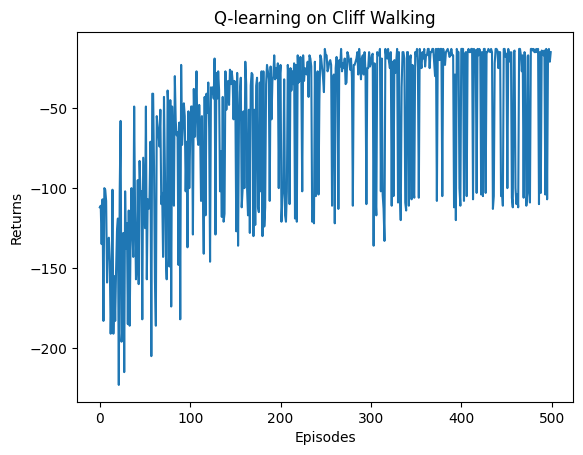

Q-learning算法最终收敛得到的策略为：
ovoo ^ooo ovoo ooo> ooo> ooo> ooo> ovoo ooo> ^ooo ovoo ovoo 
ovoo ooo> ooo> ^ooo ovoo ooo> ooo> ovoo ooo> ooo> ovoo ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [8]:
class QLearning(Sarsa):
    """ Q-learning算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        super().__init__(ncol, nrow, epsilon, alpha, gamma, n_action)

    def update(self, s0, a0, r, s1):
        TD_target =r + self.gamma * self.Q_table[s1].max()
        TD_error = TD_target- self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * TD_error


np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = QLearning(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return =train_agent_on_policy(env,agent,"Q_learning")
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on {}'.format('Cliff Walking'))
plt.show()

action_meaning = ['^', 'v', '<', '>']
print('Q-learning算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])


Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 2175.72it/s, episode=500, return=-50.300]


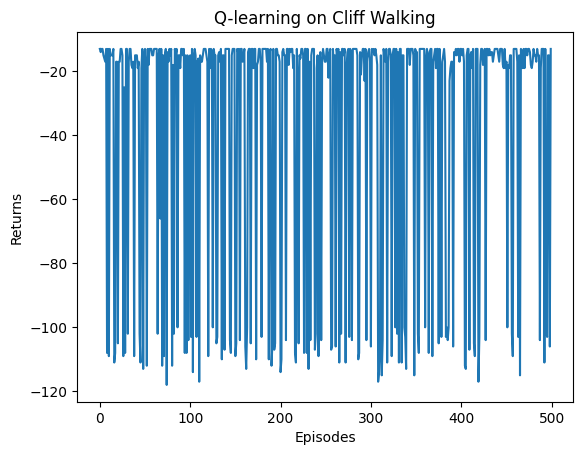

Q-learning算法最终收敛得到的策略为：
^v<> ^v<> ^o<> ^ooo ovoo ^o<o ^ooo oo<o ^v<o ovoo ^oo> ^v<> 
^o<o ^v<o oo<o oo<> ^oo> ov<o ovoo ^ooo ^v<o ^voo oo<o ^o<> 
^ooo oo<o ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo oo<o ^ooo 
ovoo **** **** **** **** **** **** **** **** **** **** EEEE 


In [9]:
def train_agent_off_policy(env,target_agent,behavior_agent):
    episode_return = 0
    state = env.reset()
    action = behavior_agent.take_action(state)
    done = False
    while not done:
        next_state, reward, done = env.step(action)
        next_action = behavior_agent.take_action(next_state)
        episode_return += reward  # 这里回报的计算不进行折扣因子衰减
        target_agent.update(state, action, reward, next_state)
        state = next_state
        action = next_action
    return episode_return

np.random.seed(0)
epsilon = 0.01
alpha = 0.1
gamma = 0.9
target_agent=QLearning(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return =train_agent_off_policy(env,target_agent,agent)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on {}'.format('Cliff Walking'))
plt.show()

action_meaning = ['^', 'v', '<', '>']
print('Q-learning算法最终收敛得到的策略为：')
print_agent(target_agent, env, action_meaning, list(range(37, 47)), [47])

In [13]:
from tqdm import trange

def collect_data(env,agent,num_episodes):
    episodes=[]
    with trange(int(num_episodes)) as t:
        for i in t:
            t.set_description("收集第 %i个episode"%(i+1))
            episode=[]
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                episode.append((state,action,reward,next_state,done))
                if done:
                    episodes.append(episode)
                    break
                next_action = agent.take_action(next_state)
                state = next_state
                action = next_action            
    return episodes

def train_agent_off_policy(episodes,target_agent):
    for episode in tqdm(episodes,desc="训练进度："):
        for step in episode:
            (state,action,reward,next_state,done)=step
            target_agent.update(state, action, reward, next_state)

def compute_return(env,agent):
    episode_return = 0
    for i in range(10):
        state = env.reset()
        action = agent.take_action(state)
        done = False
        while not done:
            next_state, reward, done = env.step(action)
            next_action = agent.take_action(next_state)
            episode_return += reward  # 这里回报的计算不进行折扣因子衰减
            state = next_state
            action = next_action
    return episode_return/10

np.random.seed(0)
epsilon = 1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes=20000
episodes=collect_data(env,agent,num_episodes/2)
#episodes.extend(collect_data(env,target_agent,num_episodes/2))


收集第 10000个episode: 100%|██████████| 10000/10000 [00:12<00:00, 814.68it/s]


In [14]:
trained_agent=QLearning(ncol, nrow, epsilon, alpha, gamma)
train_agent_off_policy(episodes,trained_agent)
total_return=compute_return(env,agent)
print(f"训练好的智能体在环境中得到的总奖励：{total_return}")

训练进度：:   0%|          | 0/10000 [00:00<?, ?it/s]

训练进度：: 100%|██████████| 10000/10000 [00:00<00:00, 34172.04it/s]

训练好的智能体在环境中得到的总奖励：-112.6


In [15]:
action_meaning = ['^', 'v', '<', '>']
print('Q-learning算法最终收敛得到的策略为：')
print_agent(trained_agent, env, action_meaning, list(range(37, 47)), [47])

Q-learning算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo ovoo ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


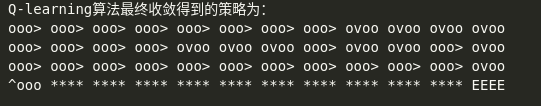  
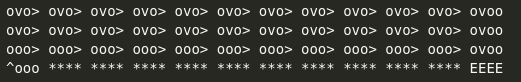